<a href="https://colab.research.google.com/github/DiegoHuesos/Tesis_deteccion_de_ruido_en_imagenes_con_algoritmo_paralelo_de_agrupamiento/blob/master/Implementacion_Experimentacion_Serial_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación y experimentación del algoritmo DBSCAN serial

En el presente código, se programa y se explica paso a paso el algoritmo `DBSCAN` que se ejecuta de forma serial. Esta implementación se basa en la propuesta inicial de [1996 by Ester et. al](https://dl.acm.org/doi/10.5555/3001460.3001507), razón por la cual, no es la implementación más óptima en la actualidad. Además, se tomó como código base el [ejercicio de DBSCAN de domino.ai](https://colab.research.google.com/github/hpcgarage/pyboot-g2s3/blob/master/supplemental/dbscan--soln.ipynb#scrollTo=VZq1TBFlwYJZ).

Posteriormente, se llevan a cabo distintos experimentos para medir el tiempo de ejecución y el uso de la memoria al ejecutar el algoritmo `DBSCAN` serial.

Se llevan a cabo dos experimentos principales: por un lado, se utilizan los conjuntos de datos de muestra (Toy Datasets) de la librería `sklearn`; por otro lado, se utilizan los conjuntos de datos sintéticos creados previamente con la función de `make_blobs()` que viene por defecto en la librería `sklearn`.

En ambos casos, se ejecuta 30 veces la función `dbscan()` para cada conjunto de datos, se mide el tiempo de ejecución y el uso de la memoria, y, por último, se guardan los resultados en archivos en formato `JSON` para su posterior análisis en conjunto de otros resultados experimentales.

La razón por la cual se determina que 30 es el número de repeticiones adecuado para la experimentación es porque este es un número comúnmente utilizado en experimentos para obtener una estimación fiable. La justificación estadística para 30 repeticiones se debe a que se considera que proporciona una muestra suficientemente grande para que el Teorema del Límite Central se aplique, permitiendo que se utilicen análisis paramétricos, asumiendo una distribución normal de los resultados.



## Importación de librerías y declaración de funciones para graficar resultados y medir uso de memoria

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import time
import psutil
import os
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.datasets import make_blobs
from PIL import Image, ImageFilter

In [ ]:
def make_scatter_plot(df, title, hue='kmeans_label'):
    # Check if 'kmeans_label' exists in the DataFrame
    if hue not in df.columns:
        raise ValueError(f"'{hue}' column not found in the DataFrame.")

    # Create the scatter plot
    plt.figure(figsize=(8, 6))  # Set the figure size

    # Use seaborn's scatterplot function
    sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1], hue=df[hue])

    plt.title(title)
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.legend(title=hue)  # Display legend with specified title
    plt.show()

def plot_dbscan_results(X_std, labels, core_samples_mask):
    # Unique labels
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        # Plot core samples
        xy = X_std[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        # Plot non-core samples
        xy = X_std[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('DBSCAN clustering')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.show()

def plot_labels (df, labels, title):
    df_labeled = df.copy ()
    df_labeled['label'] = labels
    make_scatter_plot(df_labeled, title, hue="label")

In [ ]:
def get_total_memory():
    return psutil.virtual_memory().total / (1024 * 1024)

def get_memory_usage_percentage():
    return psutil.virtual_memory().percent

def get_cpu_usage():
    cpu_usage = psutil.cpu_percent(interval=1)
    return cpu_usage

## Implementación del algoritmo serial DBSCAN

DBSCAN identifica clusters basándose en la densidad de los puntos de datos, lo que le permite descubrir grupos de formas variadas y tamaños. Se definen dos parámetros principales: el radio ϵ (epsilon), que determina el tamaño del vecindario alrededor de cada punto, y el número mínimo de puntos, minPts, necesario para formar un cluster. Un punto se considera central si dentro de su vecindario de radio ϵ hay al menos minPts.

### Vecindades (Neighborhoods)

El primer concepto importante en DBSCAN es el de una vecindad $\epsilon$.

Considerando cualquier punto $p$. La vecindad $\epsilon$ de $p$ es el conjunto de todos los puntos dentro de una distancia de $\epsilon$ desde $p$. Es decir, si ${\hat{x}_0, \hat{x}_1, \ldots, \hat{x}_{m-1}}$ es una colección de $m$ puntos de datos, entonces la vecindad $\epsilon$ centrada en $p$ es

$$
  N_{\epsilon}(p) = \{\hat{x}_i : \|\hat{x}_i - p\|_2 \leq \epsilon\},
$$

donde la medida de distancia es euclidiana (es decir, la norma dos). Nota que esta definición incluiría el punto $p$ si $p$ es uno de los puntos de datos.

Implementando una función que calcula la vecindad $\epsilon$ de $p$ para una matriz de datos de puntos, $X$, definida por

$$
  X = \left( \begin{array}{c} \hat{x}_0^T \\ \hat{x}_1^T \\ \vdots \\ \hat{x}_{m-1}^T \end{array} \right).
$$

La función `region_query(p, eps, X)` que encuentra la vecindad cuenta con los siguientes parámetros de entrada:

- `p[:d]`: El punto de consulta, de dimensión d.
- `eps`: El tamaño de la bola alrededor de p para buscar.
- `X[:m, :d]`: El conjunto de puntos, es decir, la matriz de datos.

Devuelve un arreglo booleano de Numpy adj[:m] con una entrada por punto (es decir, por fila de X). La entrada adj[i] debe ser True solo si X[i, :] se encuentra dentro de la bola de tamaño eps centrada en p.


 Suponiendo que se pasa como parámetro un vector `y[:]` de valores booleanos (`True` y `False`), como el que se calculó anteriormente. La función llamada `index_set(y)` devuelve las ubicaciones o, mejor dicho, los índices de todos los elementos `True` de `y`.

In [ ]:
def region_query (p, eps, X):
    adj = []
    for pi in X:
      d = math.sqrt( math.pow( (pi[0] - p[0]), 2) + math.pow( (pi[1] - p[1]), 2 ) )
      if d < eps or d == eps:
        adj.append(True)
      else:
        adj.append(False)
    return adj

In [ ]:
def index_set (y):
    true_indices = {index for index, value in enumerate(y) if value}
    return true_indices

Dado un valor para $\epsilon$ y una matriz de datos $X$ de puntos, la función a continuación determina la vecindad de cada punto. Devuelve una lista de Python `neighbors[:m]` tal que `neighbors[i]` es el conjunto de índices de vecinos del punto $X[i, :]$. Esta función utiliza, a su vez, las funciones auxiliares *region_query* y *index_set*.

In [ ]:
def find_neighbors (eps, X):
    neighbors = []
    for p in X:
      region_p = region_query(p, eps, X)
      neighbors.append( index_set( np.array(region_p) ) )
    return neighbors

### Densidad (Density)

El siguiente concepto importante en DBSCAN es el de la densidad de una vecindad. Intuitivamente, el algoritmo DBSCAN intentará "crecer" clusters alrededor de puntos cuyas vecindades sean suficientemente densas.

Un punto $p$ es un punto núcleo (core point) si su vecindad $\epsilon$ tiene al menos $s$ puntos.

En otras palabras, el algoritmo ahora tiene dos parámetros definidos por el usuario: el tamaño de la vecindad, $\epsilon$, y la densidad mínima, especificada usando un umbral $s$ sobre el número de puntos en dicha vecindad.

La función, `find_core_points(s, neighbors)`, a continuación, toma como entrada un umbral mínimo de puntos, `s`, y una lista de vecindades de puntos, `neighbors[:]`, tal que `neighbors[i]` es el conjunto (de índices) de vecinos del punto `i`. Devuelve un conjunto, `core_set`, tal que un índice `j in core_set` solo si el tamaño de la vecindad en `j` es al menos `s`.

In [ ]:
def find_core_points (s, neighbors):
    core_set = set ()
    for index, neighbors_of_p in enumerate(neighbors):
      if len(neighbors_of_p) >= s:
        core_set.add(index)
    return core_set

### Crecimiento de clusters mediante puntos "alcanzables"

El último concepto necesario para DBSCAN es la idea de _crecer_ un cluster alrededor de un punto núcleo. Depende de la noción de _alcanzabilidad_.

Un punto $q$ es _alcanzable_ desde otro punto $p$ si existe una secuencia de puntos $p=p_1, p_2, \ldots, p_k=q$ tal que cada $p_i$ es un punto núcleo, posiblemente excepto por $p_k=q$, y $p_{i} \in N_\epsilon(p_{i-1})$ para todo $1 < i < k$.

Este procedimiento funciona de la siguiente manera.

**Procedimiento "Expandir Cluster":**
1. Se considera cualquier punto $p$ que aún no haya sido asignado a un cluster.
2. Si $p$ es un punto núcleo, entonces se inicia un nuevo cluster para éste.
3. Se mantiene un conjunto "alcanzable", que se utilizará para contener puntos que son alcanzables desde $p$ a medida que se encuentran. Inicialmente, los puntos alcanzables son solo los $\epsilon$-vecinos de $p$.
4. Se elimina cualquier punto $q$ del conjunto alcanzable.
5. Si $q$ aún no ha sido visitado, entonces se marca como visitado.
6. Si $q$ también es un punto núcleo, entonces se agregan todos sus vecinos al conjunto alcanzable, según la definición de "alcanzabilidad" anterior.
7. Si $q$ aún no ha sido asignado a ningún cluster, entonces se agrega al cluster de $p$.

Como este procedimiento explora los puntos alcanzables desde $p$ (Paso 6). Intuitivamente, está tratando de unir todas las vecindades cuyos puntos núcleo se contienen mutuamente.

Aquí hay una breve ilustración de estos conceptos:

![Ejemplo: Crecimiento de clusters](https://github.com/hpcgarage/pyboot-g2s3/blob/master/supplemental/eps-example--small.png?raw=1)

En esta imagen, se supone que el parámetro de densidad mínima es $s=3$ puntos. Por lo tanto, solo las vecindades de $\epsilon$ centradas en 1, 3 y 6 son puntos núcleo, ya que estos son los únicos puntos que incluyen al menos $s=3$ puntos. Por ejemplo, $N_\epsilon(1) = \{0, 1, 3, 7\}$, lo que lo convierte en un punto núcleo ya que su vecindad tiene cuatro (4) puntos, mientras que $N_\epsilon(4) = \{3, 4\}$ no es un punto núcleo ya que su vecindad tiene solo dos (2) puntos.

In [ ]:
def expand_cluster (p, neighbors, core_set, visited, assignment):
    reachable = set (neighbors[p])  # Paso 3.
    while reachable:
        q = reachable.pop () # Paso 4. Eliminar cualquier punto q del conjunto alcanzable.

        if q not in visited:    # Paso 5. Si q no ha sido visitado aún, entonces se marca como visitado.
          visited.add (q)

          if q in core_set:    # Paso 6. Si q también es un punto núcleo, entonces añade todos sus vecinos al conjunto alcanzable, según la definición de "alcanzabilidad" anterior.
            reachable |= neighbors[q]

        # Paso 7. Si q no ha sido asignado a ningún clúster aún, entonces añádelo al clúster de p.
        if q not in assignment:
          assignment[q] = assignment[p]

    # Esta función no devuelve nada excepto a través de actualizaciones a `visited` y `assignment`.

El procedimiento de "crecimiento del clúster" descrito anteriormente en la función, `expand_cluster()`cuenta con los siguientes parámetros:

- `p` es el _índice_ de un punto núcleo inicial. Se debe debe garantizar que efectivamente es un punto núcleo y, además, que ha sido asignado a algún clúster.
- `neighbors[:]` es una lista de vecindades de $\epsilon$, dadas como conjuntos de Python. Por ejemplo, `neighbors[p]` es un conjunto de índices de todos los puntos en la vecindad de `p`. Esto se habrá calculado a partir de `find_neighbors()` anteriormente.
- `core_set` es un conjunto de Python que contiene los índices de todos los puntos núcleo. Es decir, la expresión, **`i in core_set`**, es verdadera solo si `i` es efectivamente un punto núcleo.
- `visited` es otro conjunto de Python que contiene los índices de todos los puntos que ya han sido visitados. Es decir, la expresión **`i in visited`** debe ser `Verdadero` solo si `i` ha sido visitado. Por lo tanto, la función `expand_cluster()` actualiza este conjunto al visitar cualquier punto previamente no visitado.
- `assignment` es un diccionario de Python. La llave (key) es el índice de un punto; el valor es la etiqueta del clúster al que se ha asignado ese punto. Por consiguiente, si un punto `i` aún no tiene ninguna asignación de clúster, entonces la expresión, **`i in assignment`**, será **`Falso`**. La función `expand_cluster()` actualiza las asignaciones de clúster actualizando este diccionario.

### Juntando todos los conceptos y funciones

A continuación, se define la función principal del algoritmo DBSCAN que recibe como parámetros una variable $eps$ de tipo float, una variable $s$ de tipo entera y una variable $X$ de tipo matriz float.

La función regresa la variable $assignment$ de tipo matriz que relaciona los puntos con el cluster asignado y la variable $core_set$ de tipo conjunto que contiene los puntos núcleo.

In [ ]:
def dbscan (eps, s, X):
    clusters = []
    point_to_cluster = {}

    neighbors = find_neighbors (eps, X)
    core_set = find_core_points (s, neighbors)

    assignment = {}
    next_cluster_id = 0

    visited = set ()
    for i in core_set:
        if i not in visited:
            visited.add (i)
            assignment[i] = next_cluster_id
            expand_cluster (i, neighbors, core_set,
                            visited, assignment)
            next_cluster_id += 1

    return assignment, core_set

## Aplicación DBSCAN serial a Toy Datasets

La librería `scikit-learn` incluye varios conjuntos de datos de muestra ([toy datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html)) que son útiles para probar algoritmos de aprendizaje automático y llevar a cabo análisis de datos. Estos conjuntos de datos son una muestra perfecta para identifcar los beneficios de la utilización del algoritmo DBSCAN.

A continuación, se aplica la implementación serial de DBSCAN a estos conjuntos de datos antes mencionados y se imprimen y grafican los resultados para comprobar de manera visual los resultados y compararlos con los resultados de sklearn.


Dataset:  iris
Dataset shape:  (150, 2)
Memory usage: 39.5
Execution Time: 0.059128761291503906
Eps: 0.199367 Min Samples: 5
Number of Core Points: 65
Number of Clusters: 7
Number of Unclassified Points: 56


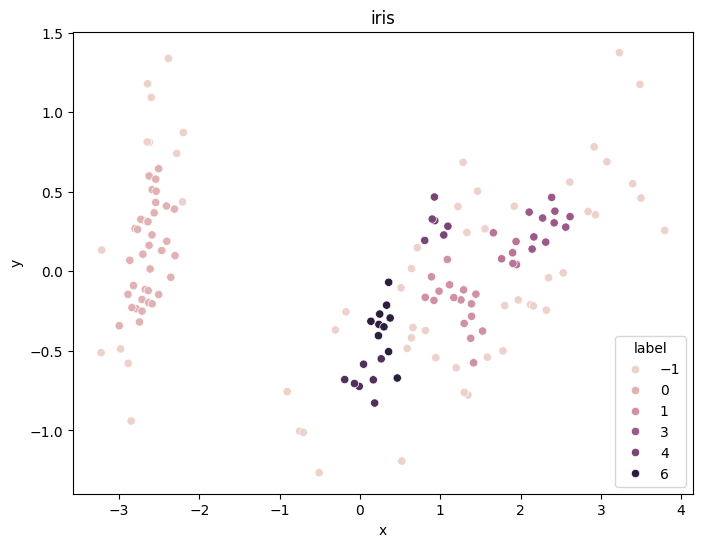


Dataset:  diabetes
Dataset shape:  (442, 2)
Memory usage: 39.5
Execution Time: 0.47528600692749023
Eps: 0.014765 Min Samples: 6
Number of Core Points: 186
Number of Clusters: 8
Number of Unclassified Points: 185


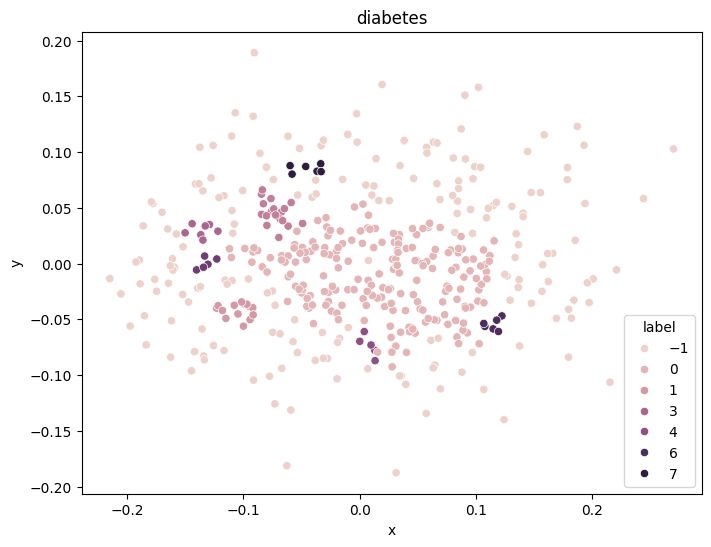


Dataset:  digits
Dataset shape:  (1797, 2)
Memory usage: 39.6
Execution Time: 7.901147365570068
Eps: 1.038251 Min Samples: 7
Number of Core Points: 350
Number of Clusters: 36
Number of Unclassified Points: 1109


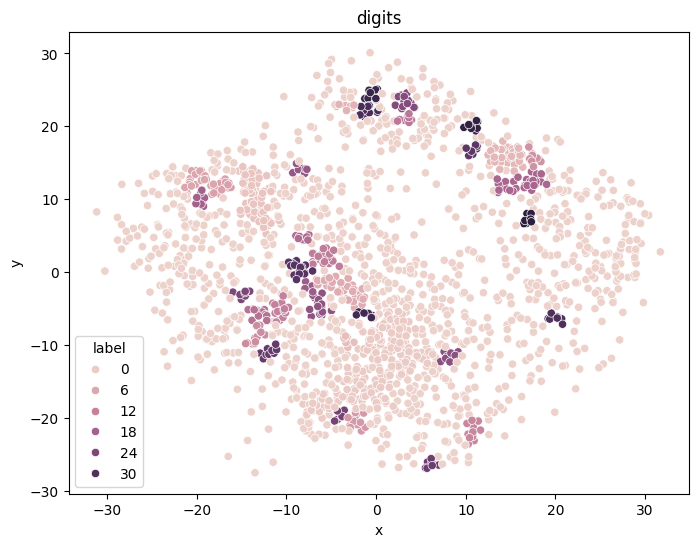


Dataset:  linnerud
Dataset shape:  (20, 2)
Memory usage: 39.6
Execution Time: 0.0006873607635498047
Eps: 41.911597 Min Samples: 2
Number of Core Points: 18
Number of Clusters: 2
Number of Unclassified Points: 2


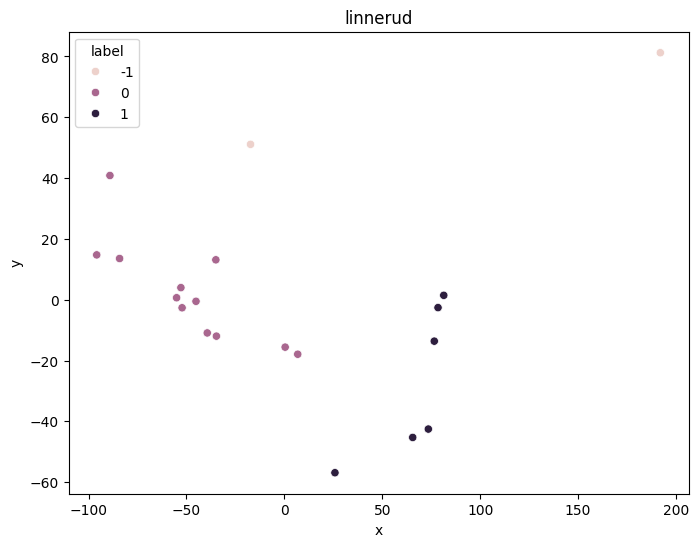


Dataset:  wine
Dataset shape:  (178, 2)
Memory usage: 39.6
Execution Time: 0.04144906997680664
Eps: 16.622963 Min Samples: 5
Number of Core Points: 90
Number of Clusters: 7
Number of Unclassified Points: 62


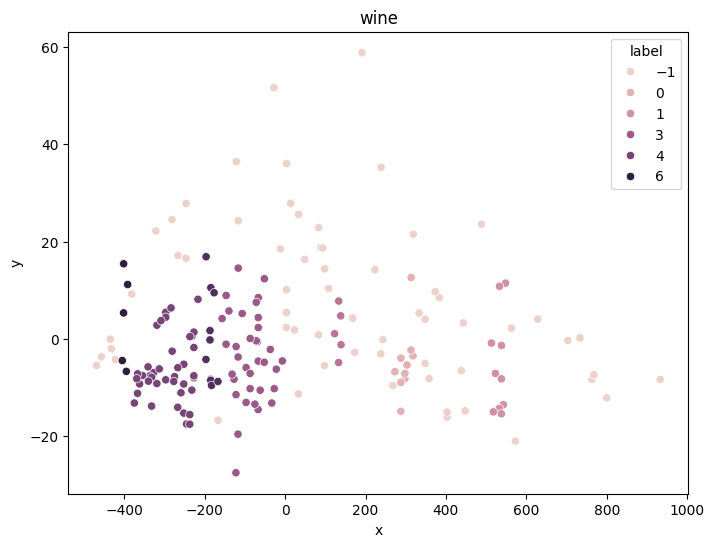


Dataset:  breast_cancer
Dataset shape:  (569, 2)
Memory usage: 39.6
Execution Time: 0.43871116638183594
Eps: 42.689478 Min Samples: 6
Number of Core Points: 392
Number of Clusters: 5
Number of Unclassified Points: 138


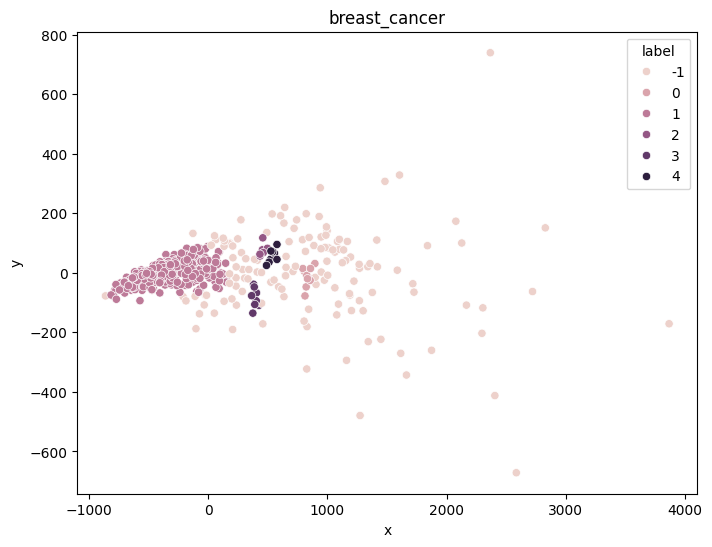

In [ ]:
# Declarar del diccionario con los conjuntos de datos de Toy Datasets y sus correspondientes valores de eps y num_samples
toy_datasets = {  'iris': {'dataset': datasets.load_iris(), 'eps': 0.199367, 'min_samples': 5},
                      'diabetes': {'dataset': datasets.load_diabetes(), 'eps': 0.014765, 'min_samples': 6},
                      'digits': {'dataset': datasets.load_digits(), 'eps': 1.038251, 'min_samples': 7},
                      'linnerud': {'dataset': datasets.load_linnerud(), 'eps': 41.911597, 'min_samples': 2},
                      'wine': {'dataset': datasets.load_wine(), 'eps': 16.622963, 'min_samples': 5},
                      'breast_cancer': {'dataset': datasets.load_breast_cancer(), 'eps': 42.689478, 'min_samples': 6}
                    }

# Iterar por cada conjunto de datos de Toy Datasets
for dataset_name, _ in toy_datasets.items():
    # Obtener el conjunto de datos
    Y = toy_datasets[dataset_name]['dataset'].data
    x_1 = toy_datasets[dataset_name]['dataset'].feature_names[0]
    x_2 = toy_datasets[dataset_name]['dataset'].feature_names[1]

    # Reducir dimensión a dos entradas
    pca = PCA(n_components=2)
    X_std = pca.fit_transform(Y)

    # Eliminar las variables auxiliares para transformar el dataset
    del Y, pca
    gc.collect()

    # Obtener los valores de eps y min_samples
    eps = toy_datasets[dataset_name]['eps']
    min_samples = toy_datasets[dataset_name]['min_samples']

    # Obtener el timpo inicial
    start_time = time.time()

    # Ejecutar DBSCAN con los valores eps y min_samples correspondientes
    assignment, core_set = dbscan (eps, min_samples, X_std)

    # Obtener el tiempo final y se lleva a cabo la diferenica para obtener el tiempo de ejecución
    execution_time = time.time() - start_time

    # Procesar resultados
    labels = [-1] * len (X_std)
    for i, c in assignment.items ():
        labels[i] = c

    # Imprimir resultados
    print("\nDataset: ", dataset_name)
    print("Dataset shape: ", X_std.shape)
    print("Memory usage:", get_memory_usage_percentage())
    print("Execution Time:", execution_time)
    print("Eps:", eps, "Min Samples:", min_samples)
    print("Number of Core Points:", len (core_set))
    print("Number of Clusters:", max(assignment.values ())+1)
    print("Number of Unclassified Points:", list(labels).count(-1))

    # Graficar clusters para visualización
    df = pd.DataFrame(X_std, columns=[x_1, x_2])
    plot_labels(df, labels, dataset_name)

## Experimentación con Toy Datasets

A continuación, se lleva a cabo la experimentación con los conjuntos de datos de muestra de la librería `sklearn` llamados [Toy Datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html).

Los valores óptimos de `eps` y `min_samples` de DBSCAN para cada conjunto de datos fue calculado previamente y sólo son agregados como un valor constante para su utilización en esta experimentación.

Los resultados de este experimento se guardan en el archivo `serial_toy_datasets_results.json`.

In [ ]:
# Declarar diccionario con los conjuntos de datos de Toy Datasets y sus correspondientes valores de eps y num_samples
toy_datasets = {  'iris': {'dataset': datasets.load_iris(), 'eps': 0.199367, 'min_samples': 5},
                  'diabetes': {'dataset': datasets.load_diabetes(), 'eps': 0.014765, 'min_samples': 6},
                  'digits': {'dataset': datasets.load_digits(), 'eps': 1.038251, 'min_samples': 7},
                  'linnerud': {'dataset': datasets.load_linnerud(), 'eps': 41.911597, 'min_samples': 2},
                  'wine': {'dataset': datasets.load_wine(), 'eps': 16.622963, 'min_samples': 5},
                  'breast_cancer': {'dataset': datasets.load_breast_cancer(), 'eps': 42.689478, 'min_samples': 6}
                }

# Iterar por cada conjunto de datos de Toy Datasets
for dataset_name, _ in toy_datasets.items():

    # Imprimir el nombre del conjunto de datos para el control de la ejecución
    print('Dataset: ', dataset_name)

    # Cargar el conjunto de datos
    Y = toy_datasets[dataset_name]['dataset'].data

    # Reducir la dimensión del conjunto de datos a sólo dos características
    pca = PCA(n_components=2)
    X_std = pca.fit_transform(Y)

    # Eliminar variables auxiliares usadas para transformar el dataset
    del Y, toy_datasets[dataset_name]['dataset'], pca
    gc.collect()

    # Obtener los valores de eps y min_samples
    eps = toy_datasets[dataset_name]['eps']
    min_samples = toy_datasets[dataset_name]['min_samples']

    # Almacenar la forma (dimensionalidad) del conjunto de datos e inicializar el diccionario de experimentos
    toy_datasets[dataset_name]['shape'] = X_std.shape
    toy_datasets[dataset_name]['experiment'] = {}

    # Repetir el experimento para poder verificar que siempre de los mismos resultados el algoritmo DBSCAN
    # y obtener tiempos de ejecución y uso de memoria.
    for i in range(30):

      # Obtener tiempo inicial
      start_time = time.time()

      # Ejecutar DBSCAN con los valores de eps y min_samples correspondientes
      assignment, core_set = dbscan (eps, min_samples, X_std)

      # Obtener el tiempo final y la diferencia para obtener el tiempo de ejecución
      execution_time = time.time() - start_time

      # Procesar resultados
      labels = [-1] * len (X_std)
      for j, c in assignment.items ():
          labels[j] = c

      # Guardar los resultados en el diccionario
      toy_datasets[dataset_name]["experiment"][i] = {
          "execution_time": execution_time,
          "memory_usage": get_memory_usage_percentage(),
          "clusters": max(assignment.values ())+1,
          "core_points": len(core_set),
          "unclassified_points": list(labels).count(-1),
          "labels": labels
      }

      # Eliminar los resultados de DBSCAN de la memoria RAM
      del assignment, core_set, labels
      gc.collect()

    # Eliminar el conjunto de datos en Y y en X_std de la memoria RAM
    del X_std
    gc.collect()

# Guardar resultados de DBSCAN en un archivo JSON para usarlos como referencia en el análisis posterior
file_name = 'serial_toy_datasets_results.json'
with open(file_name, 'w') as file:
    json.dump(toy_datasets, file, indent=4)
    print(f"Resultados guardados en {file_name}")

Dataset:  iris
Dataset:  diabetes
Dataset:  digits
Dataset:  linnerud
Dataset:  wine
Dataset:  breast_cancer
Results saved in serial_toy_datasets_results.json


# Conjuntos de datos sintéticos de distintos tamaños

A continuación, se ejecuta el algoritmo dbscan serial con los conjuntos de datos sintéticos de distintos tamaños: 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000 y 50000 puntos de dos dimensiones que se generaron utilizando la función `make_blobs` de la librería `sklearn.datasets` y se grafican los resultados.

Los valores óptimos de `eps` y `min_samples` de DBSCAN para cada conjunto de datos fue calculado previamente y sólo es agregado como un valor constante para su utilización en esta experimentación.

Los resultados de la ejecución se imprimen y se grafican.


Dataset:  5000
Dataset shape:  (5000, 2)
Memory usage: 39.6
Execution Time: 35.13965177536011
Eps: 0.4 Min Samples: 6
Number of Core Points: 4881
Number of Clusters: 2
Number of Unclassified Points: 65


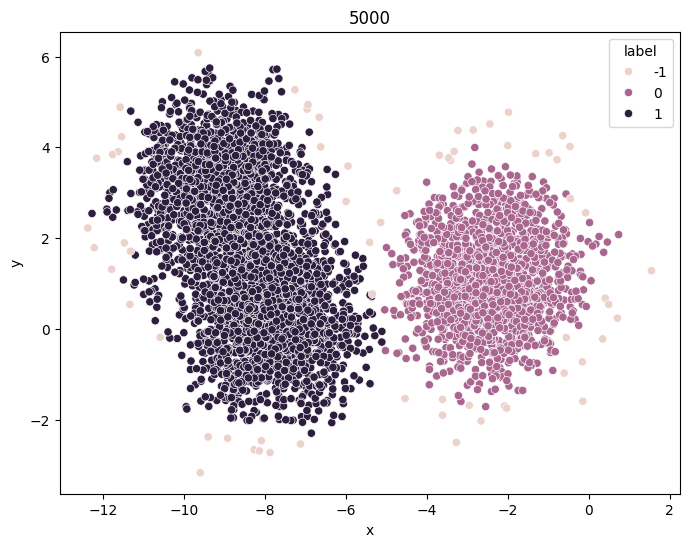

KeyboardInterrupt: 

In [ ]:
# Declarar los valores de eps y num_samples óptimos para cada conjunto de datos
datasets_eps_min_samples = {5000: {'epsilon': 0.4, 'min_samples': 6},
 10000: {'epsilon': 0.6, 'min_samples': 5},
 15000: {'epsilon': 0.8, 'min_samples': 4},
 20000: {'epsilon': 0.8, 'min_samples': 6},
 25000: {'epsilon': 0.9, 'min_samples': 4},
 30000: {'epsilon': 0.8, 'min_samples': 2},
 35000: {'epsilon': 0.8, 'min_samples': 3},
 40000: {'epsilon': 0.8, 'min_samples': 5},
 45000: {'epsilon': 0.8, 'min_samples': 9},
 50000: {'epsilon': 0.6, 'min_samples': 6}}

# Iterar por cada conjunto de datos
for num_samples in range(5000, 50001, 5000):

    # Construir el nombre del archivo JSON del dataset correspondiente
    filename = './datasets/dataset_' + str(num_samples) + '.json'

    # Abrir el archivo JSON correspondiente para cargar los datos del conjunto de datos correspondiente
    with open(filename, 'r') as f:
        data = json.load(f)

    # Obtener los datos, el valor eps y min_samples
    dataset_name = str(num_samples)
    X = np.array(data[dataset_name])
    eps = datasets_eps_min_samples[num_samples]['epsilon']
    min_samples = datasets_eps_min_samples[num_samples]['min_samples']

    # Eliminar data de la memoria RAM
    del data
    gc.collect()

    # Obtener tiempo inicial
    start_time = time.time()

    # Ejecutar DBSCAN con los valores de eps y min_samples correspondientes
    assignment, core_set = dbscan (eps, min_samples, X)

    # Obtener el tiempo final y la diferencia para obtener el tiempo
    execution_time = time.time() - start_time

    # Procesar resultados
    labels = [-1] * len (X)
    for j, c in assignment.items ():
        labels[j] = c

    # Imprimir resultados
    print("\nDataset: ", dataset_name)
    print("Dataset shape: ", X.shape)
    print("Memory usage:", get_memory_usage_percentage())
    print("Execution Time:", execution_time)
    print("Eps:", eps, "Min Samples:", min_samples)
    print("Number of Core Points:", len (core_set))
    print("Number of Clusters:", max(assignment.values ())+1)
    print("Number of Unclassified Points:", list(labels).count(-1))

    # Graficar clusters para visualización
    df = pd.DataFrame(X, columns=['x', 'y'])
    plot_labels(df, labels, str(num_samples))

    # Eliminar variables de la memoria RAM
    del X, assignment, core_set, labels
    gc.collect()

## Experimentación con conjuntos de datos sintéticos de distintos tamaños

A continuación, se lleva a cabo la experimentación con los conjuntos de datos sintéticos de distintos tamaños: 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000 y 50000 puntos de dos dimensiones que se generaron utilizando la función `make_blobs` de la librería `sklearn.datasets`.

Los valores óptimos de `eps` y `min_samples` de DBSCAN para cada conjunto de datos fue calculado previamente y sólo es agregado como un valor constante para su utilización en esta experimentación.

Los resultados de este experimento se guardan en el archivo `serial_different_size_results.json`.

In [ ]:
# Declarar los valores de eps y min_samples óptimos para cada conjunto de datos
datasets_eps_min_samples = {  5000: {'epsilon': 0.4, 'min_samples': 6},
                              10000: {'epsilon': 0.6, 'min_samples': 5},
                              15000: {'epsilon': 0.8, 'min_samples': 4},
                              20000: {'epsilon': 0.8, 'min_samples': 6},
                              25000: {'epsilon': 0.9, 'min_samples': 4},
                              30000: {'epsilon': 0.8, 'min_samples': 2},
                              35000: {'epsilon': 0.8, 'min_samples': 3},
                              40000: {'epsilon': 0.8, 'min_samples': 5},
                              45000: {'epsilon': 0.8, 'min_samples': 9},
                              50000: {'epsilon': 0.6, 'min_samples': 6} }

# Declarar diccionario para almacenar los resultados de la experimentación
different_size_datasets = {}

# Iterar por cada conjunto de datos
for num_samples in range(5000, 50001, 5000):

    # Imprimir el nombre del conjunto de datos para el control de la ejecución
    print('Dataset: ', num_samples)

    # Construir el nombre del archivo JSON del dataset correspondiente
    filename = './datasets/dataset_' + str(num_samples) + '.json'

    # Abrir el archivo JSON correspondiente para cargar los datos del conjunto de datos correspondiente
    with open(filename, 'r') as f:
        data = json.load(f)

    # Obtener los datos, el valor eps y min_samples
    dataset_name = str(num_samples)
    X = np.array(data[dataset_name])
    eps = datasets_eps_min_samples[num_samples]['epsilon']
    min_samples = datasets_eps_min_samples[num_samples]['min_samples']

    # Borrar data de la memoria RAM
    del data
    gc.collect()

    # Guardar los resultados en el diccionario
    different_size_datasets[num_samples] = {}
    different_size_datasets[num_samples]['experiment'] = {}

    # Repetir el experimento para poder verificar que siempre de los mismos resultados el algoritmo DBSCAN
    # y obtener tiempos de ejecución y uso de memoria.
    for i in range(2):

      # Obtener tiempo inicial
      start_time = time.time()

      # Ejecutar DBSCAN con los valores de eps y min_samples correspondientes
      assignment, core_set = dbscan (eps, min_samples, X)

      # Obtener el tiempo final y la diferencia para obtener el tiempo de ejecución
      execution_time = time.time() - start_time

      # Procesar resultados
      labels = [-1] * len (X)
      for j, c in assignment.items ():
        labels[j] = c

      # Guardar los resultados en el diccionario
      different_size_datasets[num_samples]["experiment"][i] = {
          "execution_time": execution_time,
          "memory_usage": get_memory_usage_percentage(),
          "clusters": max(assignment.values ())+1,
          "core_points": len(core_set),
          "unclassified_points": list(labels).count(-1),
          "labels": labels
      }

      # Eliminar variables de la memoria RAM
      del assignment, core_set, labels
      gc.collect()

    # Eliminar variables de la memoria RAM
    del X
    gc.collect()

# Guardar resultados de DBSCAN en un archivo JSON para usarlos como referencia en el análisis posterior
file_name = 'serial_different_size_results.json'
with open(file_name, 'w') as file:
    json.dump(different_size_datasets, file, indent=4)
    print(f"Resultados guardados en {file_name}")

Dataset:  5000
Dataset:  10000
Dataset:  15000
Dataset:  20000
Dataset:  25000
Dataset:  30000
Dataset:  35000
Dataset:  40000
Dataset:  45000
Dataset:  50000
Resultados guardados en serial_different_size_results.json
